In [1]:
from typing import Any

import matplotlib.pyplot as plt
import mlflow
import mlflow.artifacts
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
from mlflow.store.entities.paged_list import PagedList
from mlflow.tracking import MlflowClient

from cate.infra.mlflow import REMOTE_TRACKING_URI


In [2]:
experiment_name = "biased_data"

In [3]:
mlflow.set_tracking_uri(REMOTE_TRACKING_URI)
client = MlflowClient(tracking_uri=REMOTE_TRACKING_URI)

In [4]:
experiment = client.search_experiments(filter_string=f"name='{experiment_name}'")[0]

In [5]:
def get_child_runs(parent_run_id) -> PagedList:
    return client.search_runs(
        experiment.experiment_id,
        filter_string=f"tags.mlflow.parentRunId='{parent_run_id}'",
    )

In [6]:
def parse_run(run) -> dict[str, Any]:
    _metrics = run.to_dictionary()["data"]["metrics"]
    _tags = run.to_dictionary()["data"]["tags"]
    metrics_keys = [
        "auuc",
        "uplift_at_10",
        "uplift_at_20",
        "uplift_at_30",
        "uplift_at_40",
        "uplift_at_50",
        "uplift_at_60",
        "uplift_at_70",
        "uplift_at_80",
        "uplift_at_90",
    ]
    tags_keys = ["model", "dataset", "random_ratio"]
    return {
        **{k: _metrics[k] for k in metrics_keys},
        **{k: _tags[k] for k in tags_keys},
    }


In [7]:
dataset_names = ("criteo", "lenta", "megafon", "hillstorm")
parent_run_ids = [
    "2792b73fda3142e7a9973110a42c754e",
    "63c2354fbd92494ba4a46af185701ab6",
    "70e68a32689a47528a3034ee1ff920e8",
    "9b386d6ef1fd4804b6376a929ef45723",
]


In [8]:
df = None
for dataset_name, parent_run_id in zip(dataset_names, parent_run_ids):
    runs = get_child_runs(parent_run_id)
    data = [parse_run(run) for run in runs]
    _df = pd.DataFrame(data)
    if df is None:
        df = _df
    else:
        df = pd.concat([df, _df])
df = df.reset_index(drop=True)


In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder_model = LabelEncoder()
label_encoder_dataset = LabelEncoder()

encoded_df = df.copy()
encoded_df["model"] = label_encoder_model.fit_transform(df["model"])
encoded_df["dataset"] = label_encoder_dataset.fit_transform(df["dataset"])

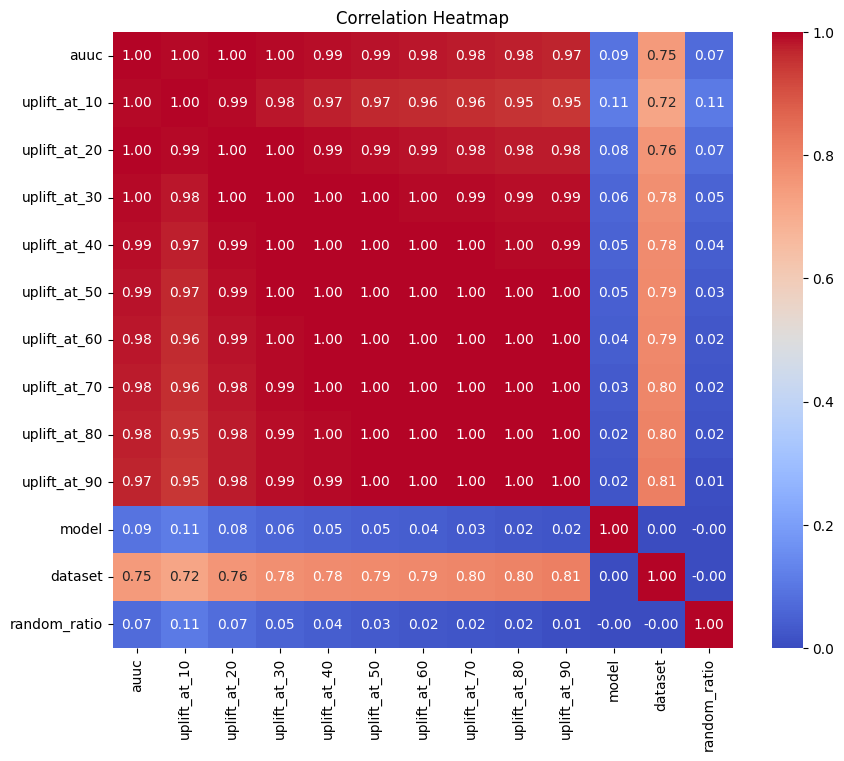

In [10]:
corr = encoded_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [19]:
dataset_flg = df["dataset"] == "criteo"
_df = df.loc[dataset_flg, ["uplift_at_20", "model", "random_ratio"]]

<Axes: xlabel='random_ratio'>

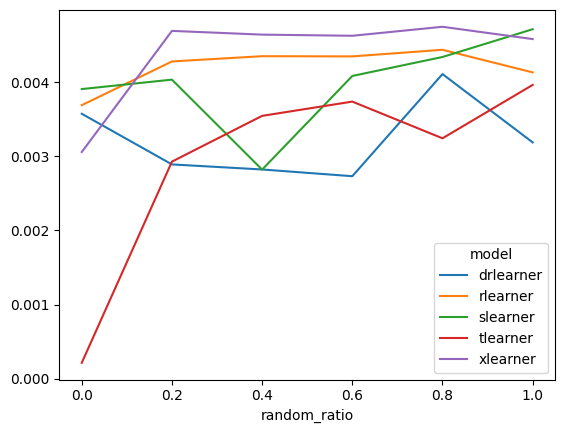

In [20]:
_df.pivot(index="random_ratio", columns="model", values="uplift_at_20").plot()

In [21]:
dataset_flg = df["dataset"] == "hillstorm"
_df = df.loc[dataset_flg, ["uplift_at_20", "model", "random_ratio"]]

<Axes: xlabel='random_ratio'>

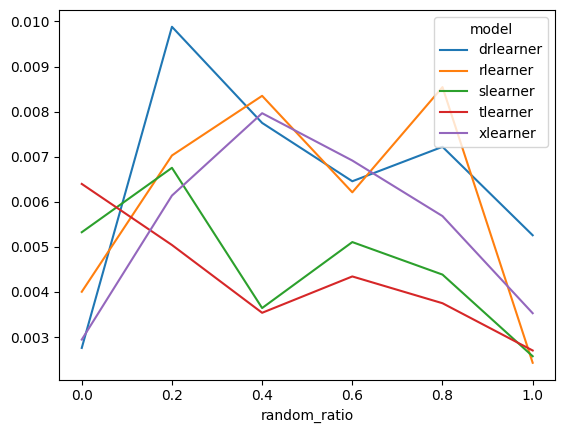

In [22]:
_df.pivot(index="random_ratio", columns="model", values="uplift_at_20").plot()

In [23]:
dataset_flg = df["dataset"] == "lenta"
_df = df.loc[dataset_flg, ["uplift_at_20", "model", "random_ratio"]]

<Axes: xlabel='random_ratio'>

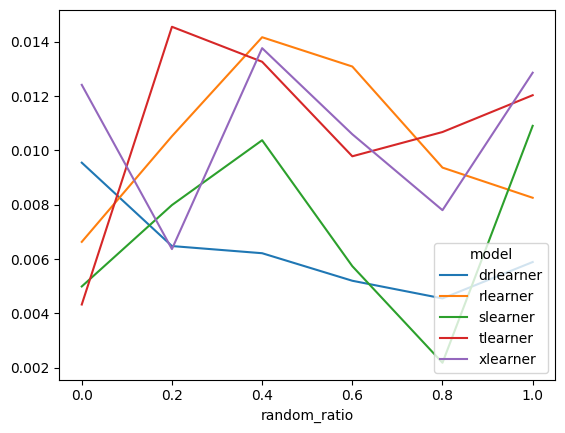

In [24]:
_df.pivot(index="random_ratio", columns="model", values="uplift_at_20").plot()


In [25]:
dataset_flg = df["dataset"] == "megafon"
_df = df.loc[dataset_flg, ["uplift_at_20", "model", "random_ratio"]]

<Axes: xlabel='random_ratio'>

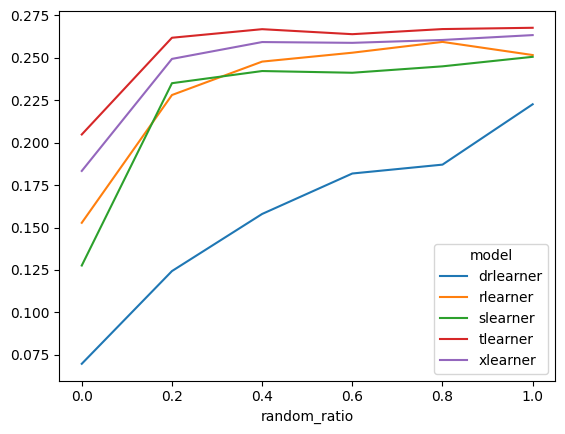

In [26]:
_df.pivot(index="random_ratio", columns="model", values="uplift_at_20").plot()
